In [1]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.2MB 1.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [49]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
from albumentations import *
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time
from IPython.display import clear_output
from scipy.ndimage.filters import gaussian_filter1d
from tqdm.notebook import tqdm
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [ ]:
!cp /content/drive/"My Drive"/mydata/clean_training_data.csv /content/
!cp /content/drive/"My Drive"/frames_raw.zip /content/
!unzip frames_raw.zip

In [5]:
df = pd.read_csv("clean_training_data.csv")
a_pop_upper_limit = 250

look_for_tag = "ceh-"
avoid_tags = ["20080819_ceh-41_14_L1",
              "20081108_ceh-36_b13_L1"]

df = df[df["A"] <= a_pop_upper_limit]
df = df[df["filenames"].str.contains(look_for_tag) == True]

for tag in avoid_tags:
    df = df[df["filenames"].str.contains(tag) == False]


print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3547 entries, 526 to 51699
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3547 non-null   int64 
 1   filenames   3547 non-null   object
 2   A           3547 non-null   int64 
 3   E           3547 non-null   int64 
 4   M           3547 non-null   int64 
 5   P           3547 non-null   int64 
 6   C           3547 non-null   int64 
 7   D           3547 non-null   int64 
 8   Z           3547 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 277.1+ KB
None


In [6]:
def preprocess_df_and_save_as_csv(df, filename="preprocessed_data.csv"):
  data =  df[["A", "E", "M", "P", "C", "D", "Z"]].values
  #scaler = MinMaxScaler()
  print("Scaler = ", scaler.fit(data))
  print("Minimum values of each column = ", scaler.data_min_)
  print("Maximum values of each column = ", scaler.data_max_)

  joblib.dump(scaler, 'scaler.gz')
  new_data = scaler.transform(data)
  print(new_data.shape)
  new_df = pd.DataFrame(new_data)
  new_df["filenames"] = df["filenames"].values
  new_df.columns = ["A", "E", "M", "P", "C", "D", "Z", "filenames"]
  final_df = new_df 
  final_df.to_csv(filename, index = False)
  final_df.tail(5)
  return(final_df)

In [7]:
scaler = MinMaxScaler()
preprocess_df_and_save_as_csv(df=df, 
                              filename="scaled_training_data.csv")

Scaler =  MinMaxScaler()
Minimum values of each column =  [0. 0. 0. 0. 0. 0. 0.]
Maximum values of each column =  [250.  14.  43.   1.  26.   8.   2.]
(3547, 7)


,A,E,M,P,C,D,Z,filenames
0,0.000,0.000000,0.000000,0.0,0.000000,0.0,0.0,frames/20080822_ceh-36b4_L1/1.jpg
1,0.000,0.000000,0.000000,0.0,0.000000,0.0,0.0,frames/20080822_ceh-36b4_L1/2.jpg
2,0.008,0.000000,0.000000,0.0,0.000000,0.0,0.0,frames/20080822_ceh-36b4_L1/3.jpg
3,0.008,0.000000,0.000000,0.0,0.000000,0.0,0.0,frames/20080822_ceh-36b4_L1/4.jpg
4,0.008,0.071429,0.000000,0.0,0.000000,0.0,0.0,frames/20080822_ceh-36b4_L1/5.jpg
...,...,...,...,...,...,...,...,...
3542,0.936,0.857143,0.883721,1.0,0.807692,1.0,1.0,frames/20081013_ceh-16_b7_L1/205.jpg
3543,0.960,0.857143,0.906977,1.0,0.807692,1.0,1.0,frames/20081013_ceh-16_b7_L1/206.jpg
3544,0.980,1.000000,0.906977,1.0,0.846154,1.0,1.0,frames/20081013_ceh-16_b7_L1/207.jpg
3545,0.980,1.000000,0.906977,1.0,0.846154,1.0,1.0,frames/20081013_ceh-16_b7_L1/208.jpg


In [8]:
class ImageDataset(Dataset):   
    def __init__(self, labels_csv_path, preprocess_image= False, augmentation =None, transform = None, RGB = False):
        
        self.df = pd.read_csv(labels_csv_path)
        self.image_paths = self.df.filenames.values
        self.labels = self.df[["A", "E", "M", "P", "C", "D", "Z"]].values
        self.transform = transform
        self.augmentation = augmentation
        self.preprocess = preprocess_image
        self.RGB = RGB

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        
        if self.RGB == False:
            image = cv2.imread(path, 0)
        else:
            image = cv2.imread(path)

        if self.preprocess == True:
            image = preprocess_image_np(image)

        if self.augmentation is not None:
            img  = self.augmentation(image = image)
            image = img["image"]
            
        label = torch.Tensor(self.labels[idx]).float()

        return self.transform(image) , label 

    def __len__(self):
        return len(self.image_paths)

In [9]:
full_dataset = ImageDataset(labels_csv_path = "scaled_training_data.csv",
                         augmentation = Compose([ 
                                                VerticalFlip(p=0.5),
                                                HorizontalFlip(p=0.5),
                                                RandomContrast(limit=0.9, p=0.5),
                                                Transpose(p=0.5),
                                                 ElasticTransform(p=0.5, alpha=30, sigma=120 * 0.05, alpha_affine=120 * 0.03)

                                            ]),
                        transform = transforms.Compose([    
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor(),
                                                        transforms.Normalize(0.5, 0.5, 0.5)
                                                        ]),
                        RGB = True ## set to true for ResNet
                            )

In [10]:
train_size = int(0.9* len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=63, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 7, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

51 batches 
51  batches 


In [13]:
def inverse_transform_prediction(output):
  lab = output.numpy().reshape(1,-1) ## convert to 2d np array
  lab = scaler.inverse_transform(lab).flatten() ## back to original domain
  lab = [int(i) for i in lab] ## convert to int 
  return lab

def show_preds(model, batch):
  fig, ax = plt.subplots(3,3, figsize = (15,15))
  images , labels = batch
  model.eval()
  preds = model(images.cuda()).cpu().detach()
  for i in range (9):
    ax.flat[i].imshow(images[i][0])
    text = "label = "+ str(inverse_transform_prediction(labels[i]))  + "  pred = " + str(inverse_transform_prediction(preds[i]))
    ax.flat[i].set_xlabel(text , fontsize= 10)

def show_batch(batch):
  fig, ax = plt.subplots(4,4, figsize = (19,19))
  images , labels = batch
  for i in range (16):
      ax.flat[i].imshow(images[i][0], cmap='gray')
      lab = inverse_transform_prediction(labels[i])
      ax.flat[i].set_xlabel("label = "+ str(lab), fontsize= 15)

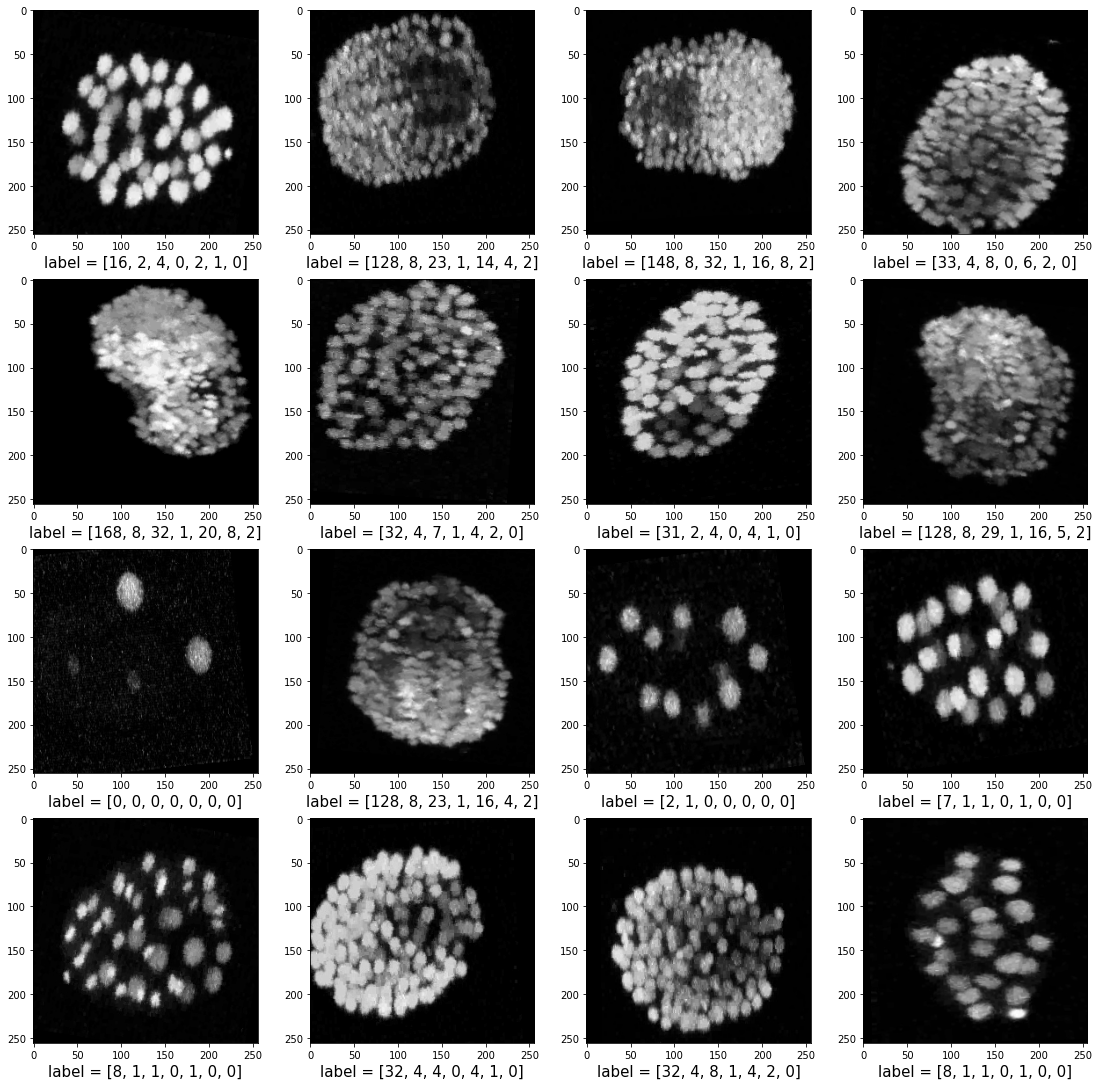

In [14]:
batch = next(iter(train_loader))
show_batch(batch)

In [32]:
def vis_loss_multi(loss_arr,val_arr):
    ysmoothed = gaussian_filter1d(loss_arr, sigma=7)
    plt.plot( ysmoothed, label = "training loss")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=18)
    plt.plot(ysmoothed2, label = "validation loss")
    plt.show()

def vis_loss_multi_colors(loss_arr,val_arr):
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize = 15)                                       
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()     

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def show_deltas(deltas):
    deltas = gaussian_filter1d(deltas, sigma=3)
    plt.plot(deltas, "r", label = "Absolute error from label ")
    plt.ylabel("Error", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

In [33]:
def train_step(x, y, model, optimizer, criterion):
        optimizer.zero_grad()
        pred = model(x)
        y = y.float()
        loss = criterion(pred,y)
        loss.backward()
        optimizer.step()
        return loss.item()


def train_model(config):

    epochs = config["epochs"]
    model = config["model"]
    train_loder = config["train_loader"]
    val_loader = config["val_loader"]
    optimizer = config["optimizer"]
    scheduler = config["scheduler"]
    criterion = config["loss_function"]

    start = time.process_time()
    losses = []
    val_losses = []
    learning_rates = []
    average_deltas = []

    for m in range (epochs):
        clear_output(wait = True)
        vis_loss_multi_colors(losses, val_losses)
        show_lr(learning_rates)
        show_deltas(average_deltas)
        print ("epoch ", m+1, " out of ", epochs )
        
        ## run on validation loader
        with torch.no_grad():
            model.eval()

            for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):
                yhat =model(x_val.cuda())  # pred 
                val_loss = criterion(yhat.cuda(), y_val.cuda())
                val_losses.append(val_loss.item())  ## metrics 
                average_deltas.append(torch.mean(torch.abs(yhat.cpu()-y_val.cpu())).item())

        ## run on train loader 
        model.train()
        for batch in tqdm(train_loader, desc = " Training batches : "):

                (x_batch, y_batch) = batch
                loss = train_step(x_batch.cuda(), y_batch.cuda(), model, optimizer, criterion)
                losses.append(loss)
                
        scheduler.step(1.)   ## lr decay caller 
        learning_rates.append(get_lr(optimizer))
        

    clear_output(wait = True)

    vis_loss_multi_colors(losses, val_losses)
    show_lr(learning_rates)
    show_deltas(average_deltas)

    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses

In [37]:
import torchvision.models as models

model = models.resnet18(pretrained = True)
model.fc = nn.Linear(512, 7)  ## resize last layer 

model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr = 0.001) 

scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.5, 
                                patience=2, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0, 
                                eps=1e-08)

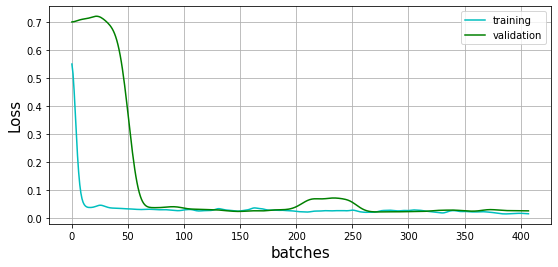

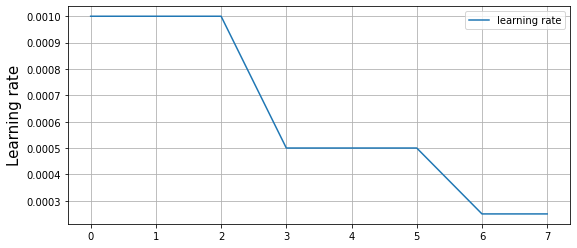

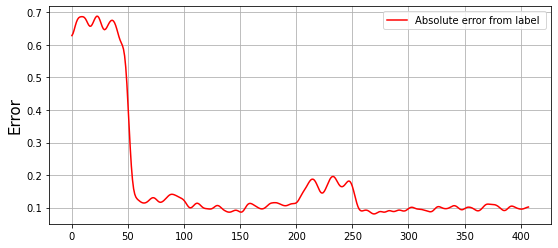

Time elapsed =  351.261428797  seconds


In [40]:
plt.rcParams["figure.figsize"] = (9,4)

config = { 
        "epochs" : 8,    
        "model" : model,      
        "train_loader" : train_loader, 
        "val_loader" : val_loader,
        "optimizer" : optimizer,
        "scheduler" : scheduler,
        "loss_function" : nn.MSELoss()
        }

losses = train_model(config)

In [42]:
save_path = "./pre_clean_l1_estimate_lineage_population_resnet18.pt"
torch.save(model.state_dict(), save_path)

In [45]:
df_test = pd.read_csv("scaled_training_data.csv")

labels = df_test[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values
filenames = df_test.filenames.values

In [46]:
mini_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize((256,256), interpolation = Image.NEAREST),
                                     transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5, 0.5)
])

In [50]:
def path_to_result(path, model):
    model.eval()
    im = cv2.imread(path)
    tensor = mini_transform(im).unsqueeze(0).cuda()
    res = model(tensor).detach().cpu().numpy().flatten()
    return res


def calc_abs_loss(pred,label):
    loss = np.sum(np.abs(pred-label))
    return loss

losses = []
preds = []

for i in tqdm(range(len(filenames))):
    pred = path_to_result(filenames[i], model )
    preds.append(pred)
    loss = calc_abs_loss(pred, labels[i])
    losses.append(loss)

losses = np.array(losses)


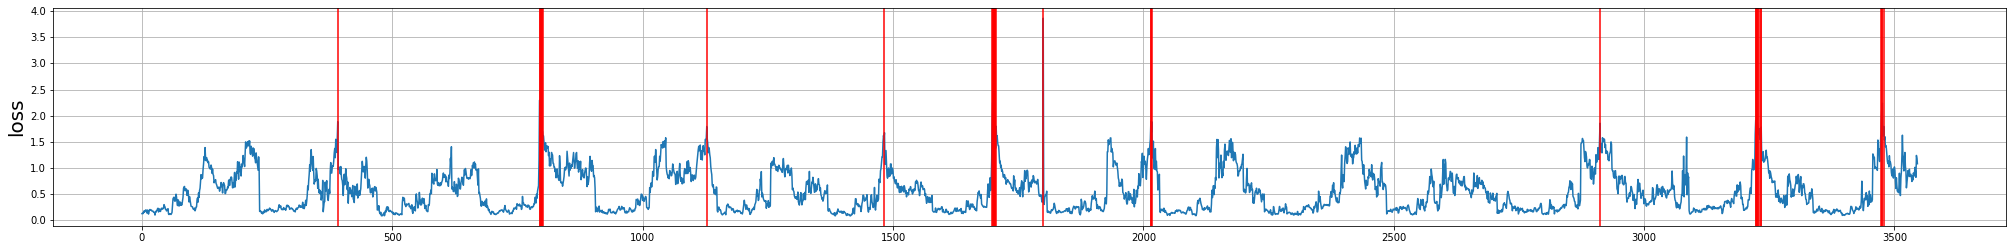

In [54]:
percentage = 1
num_bad = int((len(filenames)/100) * percentage)
indices_of_bad_pictures = (-losses).argsort()[:num_bad]

plt.rcParams["figure.figsize"] = (35,4)

plt.plot(losses)
plt.ylabel("loss", fontsize = 20)

for index in indices_of_bad_pictures:
    plt.axvline(x = index, c = "r")
plt.grid()
plt.show()


In [55]:
df_clean = df_test
df_clean = df_clean.drop(df_clean.index[indices_of_bad_pictures])
df_clean.to_csv("new_clean_training_data.csv")
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3512 entries, 0 to 3546
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          3512 non-null   float64
 1   E          3512 non-null   float64
 2   M          3512 non-null   float64
 3   P          3512 non-null   float64
 4   C          3512 non-null   float64
 5   D          3512 non-null   float64
 6   Z          3512 non-null   float64
 7   filenames  3512 non-null   object 
dtypes: float64(7), object(1)
memory usage: 246.9+ KB


In [56]:
full_dataset = ImageDataset(labels_csv_path = "new_clean_training_data.csv",
                         augmentation = Compose([ 
                                                    VerticalFlip(p=0.5),
                                                    HorizontalFlip(p=0.5),
                                                    ]),
                            transform = transforms.Compose([    
                                                            transforms.ToPILImage(),
                                                            transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                            torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                            ToTensor(),
                                                            transforms.Normalize(0.5, 0.5, 0.5)
                                                            ]),
                            RGB = True ## set to true for ResNet
                             )

train_size = int(0.9* len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=18, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 2, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

176 batches 
176  batches 


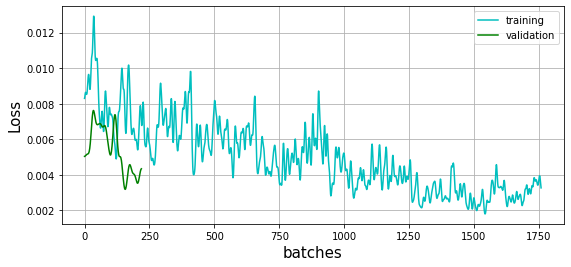

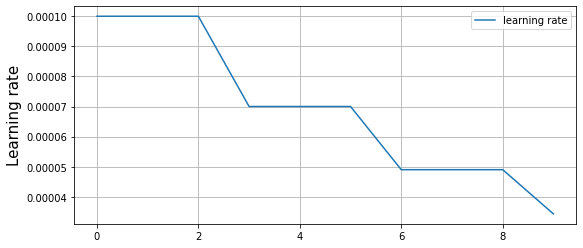

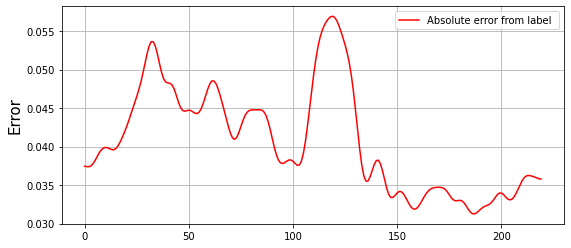

Time elapsed =  233.124179206  seconds


In [63]:
plt.rcParams["figure.figsize"] = (9,4)
optimizer = optim.Adam(model.parameters(), lr = 0.0001) 


scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.7, 
                                patience=2, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0.0000001, 
                                eps=1e-08)


config = { 
        "epochs" : 10,    
        "model" : model,      
        "train_loader" : train_loader, 
        "val_loader" : val_loader,
        "optimizer" : optimizer,
        "scheduler" : scheduler,
        "loss_function" : nn.MSELoss()
        }

losses = train_model(config)

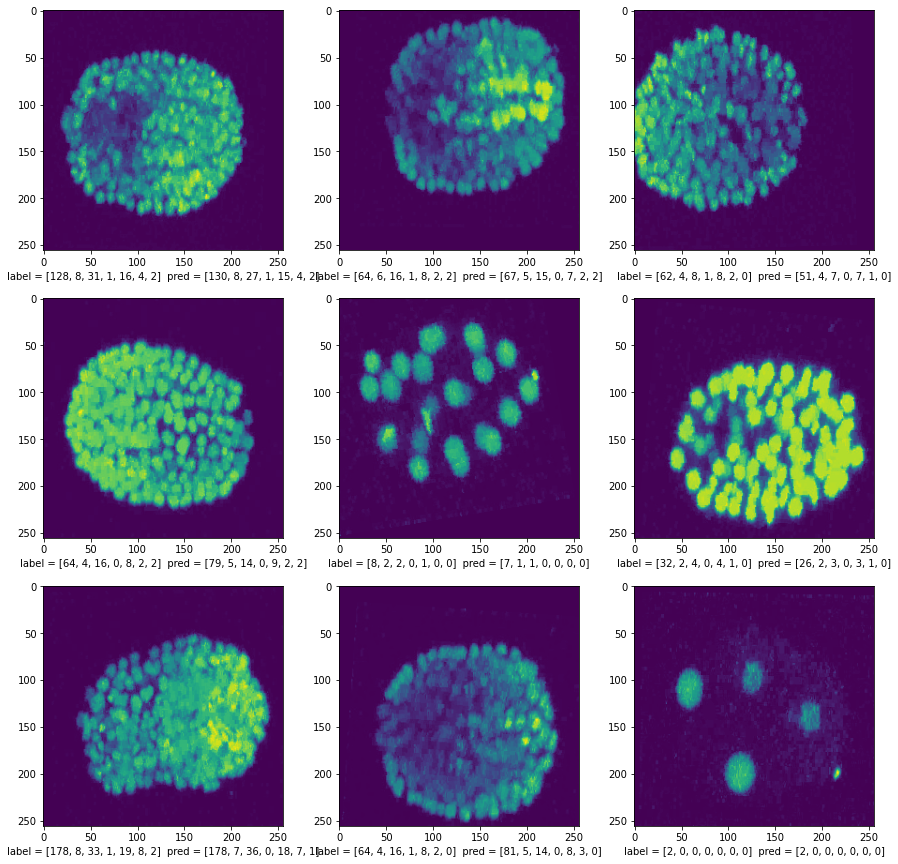

In [64]:
val_loader = DataLoader(dataset=test_dataset, batch_size= 16, shuffle = True)
batch = next(iter(val_loader))
show_preds(model , batch)